# バイオのデータを使った構造探索
- qcut → label encodingで離散化したデータを離散値に置き換え
- NO TEARSで構造学習
- ベイジアンネットワークで確率分布の学習
- それらをもとにAUCを各変数に対するAUCを計算
    - ほんとは明確なアウトカム変数に対して行うが、今回の研究ではそれが存在しない

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import LabelEncoder

from causalnex.structure import StructureModel
import networkx as nx
from causalnex.structure.notears import from_pandas

from causalnex.network import BayesianNetwork
from causalnex.discretiser import Discretiser
from causalnex.evaluation import classification_report
from causalnex.evaluation import roc_auc
from causalnex.inference import InferenceEngine
from sklearn.model_selection import train_test_split

# original package
from lab_tools.pickle_manage import *

import warnings
warnings.simplefilter('ignore')

# データ読み込みから前処理

In [38]:
df = pd.read_excel('bn/data/230828_230904_AI用qPCRデータ.xlsx', index_col=0, header=1)
df = df.dropna()
df = df.reset_index(drop=True)
df

glk           agp      yihX           pgm      ptsG          malx  \
0    0.000004  2.982088e-05  0.000004  1.512045e-05  0.000015  9.403729e-07   
1    0.000008  3.062644e-05  0.000016  2.940716e-08  0.000015  3.847846e-06   
2    0.000008  7.608227e-06  0.000016  1.396326e-08  0.000031  9.615077e-07   
3    0.000004  1.513944e-05  0.000015  1.225795e-07  0.000015  4.807837e-07   
4    0.000008  4.768491e-07  0.000031  6.105349e-08  0.000031  9.593193e-07   
..        ...           ...       ...           ...       ...           ...   
126  0.000008  3.070106e-05  0.000016  1.535654e-05  0.000031  3.839581e-06   
127  0.000008  3.099429e-05  0.000031  3.081146e-05  0.000032  7.695749e-06   
128  0.000015  3.061766e-05  0.000063  3.095131e-05  0.000063  7.836547e-06   
129  0.000015  3.050630e-05  0.000031  7.612714e-06  0.000031  1.893243e-06   
130  0.000015  3.076322e-05  0.000031  1.533943e-05  0.000031  3.868563e-06   

          crr      galM          yihR      yeaD  ...      tpiA      gapA  \
0    0.000122  0.000015  4.792578e-07  0.000007  ...  0.000008  0.000121   
1    0.000124  0.000015  3.848767e-06  0.000015  ...  0.000015  0.000123   
2    0.000245  0.000015  4.864569e-07  0.000031  ...  0.000015  0.000122   
3    0.000124  0.000015  1.207673e-07  0.000008  ...  0.000015  0.000061   
4    0.000124  0.000015  2.428970e-07  0.000016  ...  0.000016  0.000124   
..        ...       ...           ...       ...  ...       ...       ...   
126  0.000124  0.000015  1.925948e-06  0.000031  ...  0.000031  0.000247   
127  0.000124  0.000015  3.854014e-06  0.000015  ...  0.000031  0.000124   
128  0.000249  0.000031  3.893389e-06  0.000063  ...  0.000031  0.000247   
129  0.000122  0.000015  9.572219e-07  0.000008  ...  0.000015  0.000061   
130  0.000123  0.000015  1.915797e-06  0.000008  ...  0.000015  0.000061   

              pgk      gpmA      ytjc      gpmM       eno      pykF      pykA  \
0    1.193258e-07  0.000119  0.000004  0.000008  0.000015  0.000030  0.000015   
1    2.377373e-07  0.000123  0.000008  0.000016  0.000031  0.000061  0.000031   
2    9.666787e-07  0.000122  0.000008  0.000016  0.000062  0.000062  0.000031   
3    2.410427e-07  0.000061  0.000004  0.000008  0.000031  0.000062  0.000031   
4    4.795912e-07  0.000124  0.000008  0.000008  0.000031  0.000062  0.000031   
..            ...       ...       ...       ...       ...       ...       ...   
126  1.227872e-04  0.000061  0.000008  0.000015  0.000122  0.000062  0.000062   
127  6.113619e-05  0.000061  0.000008  0.000008  0.000124  0.000031  0.000031   
128  2.488283e-04  0.000122  0.000015  0.000015  0.000248  0.000122  0.000062   
129  6.136734e-05  0.000061  0.000008  0.000004  0.000061  0.000061  0.000030   
130  1.240316e-04  0.000061  0.000008  0.000008  0.000120  0.000061  0.000031   

         ppsA  
0    0.000030  
1    0.000061  
2    0.000062  
3    0.000062  
4    0.000062  
..        ...  
126  0.000123  
127  0.000061  
128  0.000123  
129  0.000031  
130  0.000031  

[131 rows x 33 columns]

In [39]:
# qcutをする
df_discrete = df.copy()

for i in range(len(df_discrete.columns)):
    df_discrete.iloc[:, i] = pd.qcut(df_discrete.iloc[:, i], 4)
    # contingency_table = pd.crosstab(df_new[])

df_discrete

glk                       agp  \
0    (-0.00099629, 7.75e-06]      (1.55e-05, 3.06e-05]   
1    (-0.00099629, 7.75e-06]      (3.06e-05, 3.09e-05]   
2    (-0.00099629, 7.75e-06]  (-0.000999523, 1.55e-05]   
3    (-0.00099629, 7.75e-06]  (-0.000999523, 1.55e-05]   
4    (-0.00099629, 7.75e-06]  (-0.000999523, 1.55e-05]   
..                       ...                       ...   
126  (-0.00099629, 7.75e-06]      (3.06e-05, 3.09e-05]   
127  (-0.00099629, 7.75e-06]       (3.09e-05, 0.00049]   
128     (7.75e-06, 1.53e-05]      (3.06e-05, 3.09e-05]   
129     (7.75e-06, 1.53e-05]      (1.55e-05, 3.06e-05]   
130     (7.75e-06, 1.53e-05]      (3.06e-05, 3.09e-05]   

                        yihX                         pgm  \
0    (-0.00099631, 1.54e-05]        (1.13e-05, 1.55e-05]   
1       (1.54e-05, 1.57e-05]  (-0.00099999236, 7.63e-06]   
2       (1.54e-05, 1.57e-05]  (-0.00099999236, 7.63e-06]   
3    (-0.00099631, 1.54e-05]  (-0.00099999236, 7.63e-06]   
4       (1.57e-05, 3.12e-05]  (-0.00099999236, 7.63e-06]   
..                       ...                         ...   
126     (1.54e-05, 1.57e-05]        (1.13e-05, 1.55e-05]   
127     (3.12e-05, 0.000496]        (1.55e-05, 0.000245]   
128     (3.12e-05, 0.000496]        (1.55e-05, 0.000245]   
129     (1.57e-05, 3.12e-05]  (-0.00099999236, 7.63e-06]   
130     (3.12e-05, 0.000496]        (1.13e-05, 1.55e-05]   

                       ptsG                      malx                   crr  \
0    (-0.00099613, 1.6e-05]  (-0.000999762, 9.66e-07]  (0.000122, 0.000123]   
1    (-0.00099613, 1.6e-05]       (2.9e-06, 0.000494]  (0.000123, 0.000124]   
2       (3.14e-05, 3.2e-05]  (-0.000999762, 9.66e-07]   (0.000124, 0.00398]   
3    (-0.00099613, 1.6e-05]  (-0.000999762, 9.66e-07]  (0.000123, 0.000124]   
4       (3.14e-05, 3.2e-05]  (-0.000999762, 9.66e-07]  (0.000123, 0.000124]   
..                      ...                       ...                   ...   
126     (3.14e-05, 3.2e-05]       (2.9e-06, 0.000494]   (0.000124, 0.00398]   
127     (3.14e-05, 3.2e-05]       (2.9e-06, 0.000494]  (0.000123, 0.000124]   
128     (3.2e-05, 0.000502]       (2.9e-06, 0.000494]   (0.000124, 0.00398]   
129     (1.6e-05, 3.14e-05]      (9.66e-07, 1.93e-06]  (0.000122, 0.000123]   
130     (1.6e-05, 3.14e-05]       (2.9e-06, 0.000494]  (0.000122, 0.000123]   

                     galM                       yihR                     yeaD  \
0    (7.68e-06, 1.53e-05]       (2.42e-07, 4.83e-07]  (-0.00099841, 7.54e-06]   
1    (1.53e-05, 1.54e-05]        (9.7e-07, 0.000492]     (7.81e-06, 1.59e-05]   
2    (7.68e-06, 1.53e-05]        (4.83e-07, 9.7e-07]     (1.59e-05, 0.000505]   
3    (1.53e-05, 1.54e-05]  (-0.0009999401, 2.42e-07]     (7.54e-06, 7.81e-06]   
4    (1.53e-05, 1.54e-05]       (2.42e-07, 4.83e-07]     (7.81e-06, 1.59e-05]   
..                    ...                        ...                      ...   
126  (1.53e-05, 1.54e-05]        (9.7e-07, 0.000492]     (1.59e-05, 0.000505]   
127  (1.53e-05, 1.54e-05]        (9.7e-07, 0.000492]     (7.81e-06, 1.59e-05]   
128  (1.54e-05, 0.000245]        (9.7e-07, 0.000492]     (1.59e-05, 0.000505]   
129  (7.68e-06, 1.53e-05]        (4.83e-07, 9.7e-07]     (7.54e-06, 7.81e-06]   
130  (1.53e-05, 1.54e-05]        (9.7e-07, 0.000492]     (7.54e-06, 7.81e-06]   

     ...                     tpiA                     gapA  \
0    ...  (-0.00099841, 7.75e-06]     (6.23e-05, 0.000124]   
1    ...     (1.55e-05, 1.58e-05]     (6.23e-05, 0.000124]   
2    ...     (7.75e-06, 1.55e-05]     (6.23e-05, 0.000124]   
3    ...     (7.75e-06, 1.55e-05]  (-0.00099254, 6.13e-05]   
4    ...     (1.55e-05, 1.58e-05]     (6.23e-05, 0.000124]   
..   ...                      ...                      ...   
126  ...     (1.58e-05, 0.000499]     (0.000124, 0.000983]   
127  ...     (1.58e-05, 0.000499]     (6.23e-05, 0.000124]   
128  ...     (1.58e-05, 0.000499]     (0.000124, 0.000983]   
129  ...     (7.75e-06, 1.55e-05]     (6.13e-05, 6.23e-05]   
130

In [44]:
type(df_discrete.iloc[0,0])

pandas._libs.interval.Interval

In [40]:
# qcutをしたデータに対してラベルエンコーディング
struct_data = df_discrete.copy()

le = LabelEncoder()
for col in struct_data.columns:
    struct_data[col] = le.fit_transform(struct_data[col])

struct_data

glk  agp  yihX  pgm  ptsG  malx  crr  galM  yihR  yeaD  ...  tpiA  gapA  \
0      0    1     0    2     0     0    1     1     1     0  ...     0     2   
1      0    2     1    0     0     3    2     2     3     2  ...     2     2   
2      0    0     1    0     2     0    3     1     2     3  ...     1     2   
3      0    0     0    0     0     0    2     2     0     1  ...     1     0   
4      0    0     2    0     2     0    2     2     1     2  ...     2     2   
..   ...  ...   ...  ...   ...   ...  ...   ...   ...   ...  ...   ...   ...   
126    0    2     1    2     2     3    3     2     3     3  ...     3     3   
127    0    3     3    3     2     3    2     2     3     2  ...     3     2   
128    1    2     3    3     3     3    3     3     3     3  ...     3     3   
129    1    1     2    0     1     1    1     1     2     1  ...     1     1   
130    1    2     3    2     1     3    1     2     3     1  ...     1     0   

     pgk  gpmA  ytjc  gpmM  eno  pykF  pykA  ppsA  
0      0     2     0     1    0     0     0     1  
1      0     3     1     3    0     1     2     2  
2      0     2     1     3    1     2     2     2  
3      0     1     0     1    0     1     2     2  
4      0     3     1     2    0     2     3     2  
..   ...   ...   ...   ...  ...   ...   ...   ...  
126    2     1     1     2    2     1     3     3  
127    0     0     1     1    2     0     1     2  
128    3     2     2     2    3     3     3     3  
129    1     1     1     0    1     0     1     1  
130    2     0     1     1    2     0     2     1  

[131 rows x 33 columns]

# 構造学習

In [74]:
# 構造学習
sm = from_pandas(struct_data)

In [75]:
# オブジェクトを保存
output_object(sm, "sm.pickle", "./")

[]

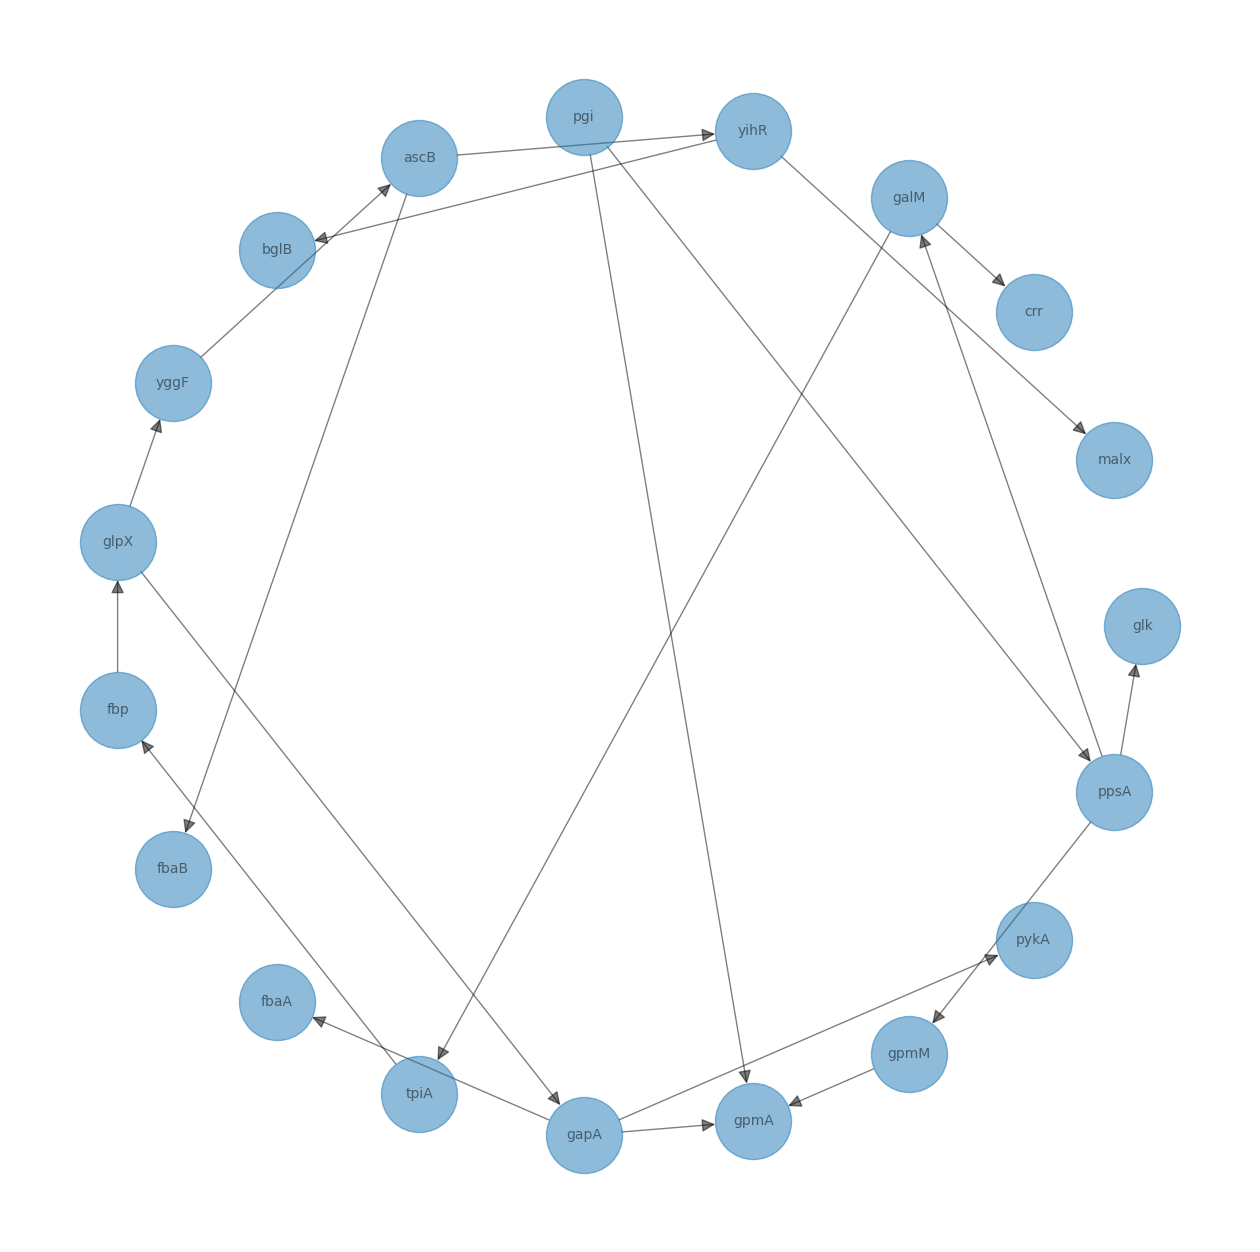

In [76]:
# 閾値を設定し、残すエッジを決める
sm.remove_edges_below_threshold(0.4)

# エッジが伸びてないノードを消す
edge_width = [ d["weight"]*1 for (u, v, d) in sm.edges(data=True)]
sm_l = sm.get_largest_subgraph()

# ネットワーク図を描画
fig, ax = plt.subplots(figsize=(16,16))
nx.draw_circular(sm_l,
                 with_labels=True,
                 font_size=10,
                 node_size=3000,
                 arrowsize=20,
                 alpha=0.5,
                 ax=ax)
plt.plot()

# ベイジアンネットワーク

In [48]:
bn = BayesianNetwork(sm_l)

## 離散化処理

In [49]:
# DAGに存在しているノードのみのデータフレームを作成
discretised_data = struct_data[[x for x in sm_l.nodes]]
# # 列ごとのユニークな値を辞書のValueとして登録
# data_vals = {col: data[col].unique() for col in data.columns}
# # 0: no-failure, 1~3: have-failureとする
# failures_map = {v: "no-failure" if v == [0] else "have-failure" 
#                 for v in data_vals["failures"]}
# # 1~2:short-studytime, 3~4:long-studytimeとする 
# studytime_map = {v: "short-studytime" if v in [1,2] else "long-studytime"
#                  for v in data_vals["studytime"]}
# # 上二つのマッピングを実行
# discretised_data["failures"] = discretised_data["failures"].map(failures_map)
# discretised_data["studytime"] = discretised_data["studytime"].map(studytime_map)

# # 離散化処理を行う
# # uniform: 均一に分割
# # quantile: 分位数で分割
# # fixed: numeric_split_pointsで指定した値で分割
# discretised_data["absences"] = Discretiser(method="fixed",
#                                           numeric_split_points=[1,10]).transform(discretised_data["absences"].values)
# discretised_data["G1"] = Discretiser(method="fixed",
#                           numeric_split_points=[10]).transform(discretised_data["G1"].values)
# discretised_data["G2"] = Discretiser(method="fixed",
#                           numeric_split_points=[10]).transform(discretised_data["G2"].values)
# discretised_data["G3"] = Discretiser(method="fixed",
#                           numeric_split_points=[10]).transform(discretised_data["G3"].values)

# # 離散化したデータをマッピングする
# absences_map = {0: "No-absence", 1:"Low-absence", 2:"High-absence"}
# G1_map = {0: "Fail", 1: "Pass"}
# G2_map = {0: "Fail", 1: "Pass"}
# G3_map = {0: "Fail", 1: "Pass"}
# discretised_data["absences"] = discretised_data["absences"].map(absences_map)
# discretised_data["G1"] = discretised_data["G1"].map(G1_map)
# discretised_data["G2"] = discretised_data["G2"].map(G2_map)
# discretised_data["G3"] = discretised_data["G3"].map(G3_map)

discretised_data

glk  malx  crr  galM  yihR  pgi  ascB  bglB  yggF  glpX  fbp  fbaB  fbaA  \
0      0     0    1     1     1    0     0     0     1     0    0     1     3   
1      0     3    2     2     3    2     3     3     3     3    2     0     2   
2      0     0    3     1     2    2     1     2     3     2    2     1     3   
3      0     0    2     2     0    1     0     0     0     1    0     2     2   
4      0     0    2     2     1    2     1     1     1     2    2     2     3   
..   ...   ...  ...   ...   ...  ...   ...   ...   ...   ...  ...   ...   ...   
126    0     3    3     2     3    1     2     3     2     2    2     0     3   
127    0     3    2     2     3    1     2     3     3     3    3     0     2   
128    1     3    3     3     3    3     3     3     3     3    3     0     3   
129    1     1    1     1     2    0     0     2     1     0    0     2     0   
130    1     3    1     2     3    1     2     3     2     1    1     3     0   

     tpiA  gapA  gpmA  gpmM  pykA  ppsA  
0       0     2     2     1     0     1  
1       2     2     3     3     2     2  
2       1     2     2     3     2     2  
3       1     0     1     1     2     2  
4       2     2     3     2     3     2  
..    ...   ...   ...   ...   ...   ...  
126     3     3     1     2     3     3  
127     3     2     0     1     1     2  
128     3     3     2     2     3     3  
129     1     1     1     0     1     1  
130     1     0     0     1     2     1  

[131 rows x 19 columns]

In [50]:
train, test = train_test_split(discretised_data, train_size=0.9, test_size=0.1)

In [51]:
bn = bn.fit_node_states(discretised_data)
bn = bn.fit_cpds(train)

In [52]:
bn.cpds["glk"]

ppsA         0         1         2         3
glk                                         
0     0.310345  0.166667  0.370370  0.161290
1     0.137931  0.333333  0.148148  0.322581
2     0.379310  0.266667  0.222222  0.225806
3     0.172414  0.233333  0.259259  0.290323

# 評価

In [ ]:
predictions = bn.predict(discretised_data, "glk")
print(discretised_data.loc[1, "glk"])

In [54]:
display(classification_report(bn, test, "glk"))

{'glk_0': {'precision': 0.4,
  'recall': 0.5,
  'f1-score': 0.4444444444444445,
  'support': 4},
 'glk_1': {'precision': 0.4,
  'recall': 0.4,
  'f1-score': 0.4000000000000001,
  'support': 5},
 'glk_2': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 0},
 'glk_3': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 5},
 'accuracy': 0.2857142857142857,
 'macro avg': {'precision': 0.2,
  'recall': 0.225,
  'f1-score': 0.21111111111111114,
  'support': 14},
 'weighted avg': {'precision': 0.2571428571428572,
  'recall': 0.2857142857142857,
  'f1-score': 0.2698412698412699,
  'support': 14}}

In [55]:
for n in bn.nodes:
    roc, auc = roc_auc(bn, test, n)
    print(n, auc)

galM 0.7891156462585034
crr 0.7908163265306123
tpiA 0.8231292517006803
yihR 0.8894557823129252
malx 0.8435374149659863
bglB 0.9047619047619047
pgi 0.30952380952380953
gpmA 0.8886054421768708
ppsA 0.641156462585034
ascB 0.7891156462585035
fbaB 0.7576530612244897
yggF 0.8443877551020408
glpX 0.7738095238095237
gapA 0.8333333333333334
fbp 0.8027210884353742
fbaA 0.7414965986394557
pykA 0.9251700680272109
gpmM 0.7210884353741497
glk 0.5153061224489796
